# Modelo Random Forest 🌳

En este cuaderno, se aplica un modelo predictivo de random forest para predecir si una empresa quebrará. Particularmente buscamos predecir la variable indicadora de quiebra `status_label` que toma los valores `alive`, si la empresa no ha quebrado y `failed`, en el caso contrario.


Entonces predecimos:

$$\widehat{status\_label} = f(\mathbf{X})$$

Donde **X** es un vector de hasta 19 variables explicativas que incluye distintos indicadores financieros como los activos netos de la empresa, su ebitda, el costo por unidad vendida, el valor de mercado y el año, entre otras variables. La función $f(·)$ entonces, es una máquina predictiva con el algoritmo de random forest.



Buscamos obtener algoritmos diversos entre los arboles, por lo cual implementamos un muestreo sin reemplazo (*bootstrap aggregating o bagging*). Posteriormente, analizamos los errores dentro de los datos de prueba, para distintos tipos de hiperparámetros, buscando maximizar el *F1-Score*. Usamos datos de prueba, en vez de los datos no seleccionados por el muestreo (*out of bag*) para facilitar la comparación entre modelos que no utilizan el bagging.



# Librerias e importaciones

In [ ]:
# Instalamos librerías
!pip install -q pandas numpy scikit-learn xgboost matplotlib \
seaborn

# Realizamos las importaciones necesarias

# Generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score,
                          silhouette_score, classification_report, f1_score)

# Para el random forest
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Carga de datos

Comenzamos importando el modulo de Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Procedemos a cargar la base y cargamos información básica sobre esta para verificar que sirva correctamente.

In [ ]:
"""
DATASET: American Bankruptcy Data
Link: https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset?resource=download

Descripción: Contiene indicadores financieros de empresas en Estados Unidos,
a una variable que indíca si la empresa se quebró o no. Esta base es un panel de
datos entre 1999 y 2018.

Variables principales:
- company_name: Identifica a cada empresa
- status_label: Determina si la empresa sigue operando (alive,failed)
- year: Año de la observación
- current_assets: Activos corrientes
- total_assets: Activos totales
- total_long_term_debt: Deuda a largo plazo
- ebit: Ganancias antes de impuestos
- gross_profit: Beneficios brutos
- total_current_liabilities: Pasivo corriente total
- retained_earnings: Ganancias retenidas
- total_revenue: Ingresos totales
- total_liabilities: Pasivo total
- total_operating_expenses: Gastos operativos totales
- cost_of_goods_sold: Costo de los bienes vendidos
- depreciation_amortization: Depreciación y amortización
- ebitda: Beneficios antes de impuestos y depreciación y amortización
- inventory: Inventario total
- net_income: Ingresos netos
- total_receivables: Recibables totales
- market_value: Valor de mercado
- net_sales: Ventas brutas

Total de registros disponibles = 78,682
"""

# Carga
df_empresas = pd.read_csv\
 ('/content/drive/MyDrive/HE2 IA parcial 1/data/american_bankruptcy_renamed.csv')

print("Información del dataset cargado:")
print(f"Dimensiones: {df_empresas.shape}")
print(f"Columnas: {list(df_empresas.columns)}")
print("\nDistribución de la variable objetivo:")
print(df_empresas['status_label'].value_counts(normalize=True))

Información del dataset cargado:
Dimensiones: (78682, 21)
Columnas: ['company_name', 'status_label', 'year', 'current_assets', 'cost_of_goods_sold', 'depreciation_amortization', 'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value', 'net_sales', 'total_assets', 'total_long_term_debt', 'ebit', 'gross_profit', 'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities', 'total_operating_expenses']

Distribución de la variable objetivo:
status_label
alive     0.933657
failed    0.066343
Name: proportion, dtype: float64


# Procesamiento de datos

Creamos una función que procesa los datos antes de separarlos e implementarlos en el modelo. No nos preocupamos por estandarizar o normalizar variables, pues los arboles de decisión analizan cada variable de forma independiente, por lo cual su escala y varianza no es relevante.

In [ ]:
# Procesamiento de datos
def procesamiento_american_bankruptcy(raw):
    """
    Procesa la base de datos de empresas para hacerla apta para un random forest.
    Devuelve un vector de variables dependientes y una matriz de covariables.
    """

    # Creamos una lista de variables numericas (casi todas)
    vars_numericas = ['current_assets', 'total_assets', 'total_long_term_debt',
                      'ebit', 'gross_profit', 'total_current_liabilities',
                      'retained_earnings', 'total_revenue', 'total_liabilities',
                      'total_operating_expenses', 'cost_of_goods_sold',
                      'depreciation_amortization', 'ebitda', 'inventory',
                      'net_income', 'total_receivables', 'market_value',
                      'net_sales', "year", "company_name"]

    # Creamos una lista con nuestra dos variable categórica de interés
    # No usamos company_name, pues separar entre empresas aumenta la
    # dimensionalidad excesivamente y el modelo puede aprender a predecir que
    # las empresas que sabe que van a fallar fallarán.
    vars_categoricas = ['status_label'] # Sabemos ya que tiene solo dos valores

    # Codificamos la variable status label. Usamos un loop, incluso si es solo
    # una variable, por si se desea expandir la base de datos con otras
    # variables categóricas
    for var in vars_categoricas:
        le = LabelEncoder()
        raw[var] = le.fit_transform(raw[var].astype(str))

    # Separamos la variable predicha de los predictores y dejamos los años y,
    # nombres de las firmas para hacer nuestro split.
    X = raw[vars_numericas]
    y = raw[['status_label', "year", "company_name"]]

    return X, y

# Corremos la función con nuestra base
X, y = procesamiento_american_bankruptcy(df_empresas)

Ahora verificamos que los datos se hayan procesado de forma adecuada.

In [ ]:
# Verificación
print("\nDatos después del preprocesamiento:")
print(f"Forma de X: {X.shape}")
print(f"Primeras 3 columnas de X:\n{X.iloc[:5, :3]}")
print(f"\nDistribución de y: {y.value_counts("status_label")}")

print(df_empresas.dtypes)


Datos después del preprocesamiento:
Forma de X: (78682, 20)
Primeras 3 columnas de X:
   current_assets  total_assets  total_long_term_debt
0         511.267       740.998               180.447
1         485.856       701.854               179.987
2         436.656       710.199               217.699
3         396.412       686.621               164.658
4         432.204       709.292               248.666

Distribución de y: status_label
0    73462
1     5220
Name: count, dtype: int64
company_name                  object
status_label                   int64
year                           int64
current_assets               float64
cost_of_goods_sold           float64
depreciation_amortization    float64
ebitda                       float64
inventory                    float64
net_income                   float64
total_receivables            float64
market_value                 float64
net_sales                    float64
total_assets                 float64
total_long_term_debt       

#Bagging y separación de datos en el Random Forest

Nuestra función de random forest incorpora de forma automática el separamiento de datos por medio del bagging. Sin embargo dejamos datos de prueba y datos de entrenamiento para hacer comparaciones entre modelos con los mismos datos. Hacemos una separación por periodos de tiempo. A la vez, mantuvimos la separación por medio de bagging porque esto da una mayor diversidad a nuestros datos. A continuación separamos los datos.

In [17]:
# year → fecha (1/jul del mismo año) SOLO para ORDENAR temporalmente
X["__date__"] = pd.to_datetime(X["year"].astype(int).astype(str) + "-07-01", errors="raise")
y["__date__"] = pd.to_datetime(y["year"].astype(int).astype(str) + "-07-01", errors="raise")

# Orden por tiempo y firma
X = X.sort_values(["__date__", "company_name"]).reset_index(drop=True)
y = y.sort_values(["__date__", "company_name"]).reset_index(drop=True)

# Separamos los datos
print("Haciendo split temporal (80% años para train, 20% años para test).")
unique_dates = X["__date__"].drop_duplicates().sort_values().values

cut_idx = int((0.8) * len(unique_dates))
cut_date = unique_dates[cut_idx]

# La separación hace el split para cada base
X_train = X[X["__date__"] < cut_date].copy()
X_test  = X[X["__date__"] >= cut_date].copy()

y_train = y[y["__date__"] < cut_date].copy()
y_test  = y[y["__date__"] >= cut_date].copy()

# Guardamos las bases en una lista con sus nombres
datasets = [("X_train", X_train), ("X_test", X_test), ("y_train", y_train), ("y_test", y_test)]

# Verificación de años
print(f"      Años en TRAIN: {pd.to_datetime(X_train['__date__']).dt.year.unique().min()}–{pd.to_datetime(X_train['__date__']).dt.year.unique().max()}")
print(f"      Años en TEST : {pd.to_datetime(X_test['__date__']).dt.year.unique().min()}–{pd.to_datetime(X_test['__date__']).dt.year.unique().max()}")

# Eliminamos variables temporales y verificamos
for name, df in datasets:
  if name in ["X_train", "X_test"]:
    globals()[name] = df.drop(columns=["__date__", "year", "company_name"])
  elif name in ["y_train", "y_test"]:
      globals()[name] = df.drop(columns=["__date__", "year", "company_name"])
  print("\n")
  print(f"{name} tiene las variables:")
  print(globals()[name].dtypes)

# Export the datasets to CSV files
output_dir = '/content/drive/MyDrive/HE2 IA parcial 1/data/'
X_train.to_csv(f'{output_dir}X_train.csv', index=False)
X_test.to_csv(f'{output_dir}X_test.csv', index=False)
y_train.to_csv(f'{output_dir}y_train.csv', index=False)
y_test.to_csv(f'{output_dir}y_test.csv', index=False)

print(f"\nDatasets exported to {output_dir}")

Haciendo split temporal (80% años para train, 20% años para test).
      Años en TRAIN: 1999–2014
      Años en TEST : 2015–2018


X_train tiene las variables:
current_assets               float64
total_assets                 float64
total_long_term_debt         float64
ebit                         float64
gross_profit                 float64
total_current_liabilities    float64
retained_earnings            float64
total_revenue                float64
total_liabilities            float64
total_operating_expenses     float64
cost_of_goods_sold           float64
depreciation_amortization    float64
ebitda                       float64
inventory                    float64
net_income                   float64
total_receivables            float64
market_value                 float64
net_sales                    float64
dtype: object


X_test tiene las variables:
current_assets               float64
total_assets                 float64
total_long_term_debt         float64
ebit               

# Implementación del modelo

A continuación implementamos el modelo óptimo con los parametros que maximizan el f1-score. Más adelante puede ver porque elegimos esta métrica y aquellos parámetros.

In [ ]:

# Implementamos el random forest
models = {
   'DecisionTree': DecisionTreeClassifier(
       criterion='gini',   # Criterio de división: 'gini' o 'entropy'
       max_depth=10,           # Profundidad máxima (menor = menos overfitting)
       min_samples_split=50,  # Mínimo de muestras para dividir un nodo
       min_samples_leaf=6,   # Mínimo de muestras en una hoja
       random_state=42
   )}


#Entrenamiento y predicciones

predictions = {}
probabilities = {}

for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train, y_train)

    predictions[name] = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        probabilities[name] = model.predict_proba(X_test)[:, 1]
    else:
        probabilities[name] = model.decision_function(X_test)

for name, preds in predictions.items():
    print(f"\nResultados de {name}:")
    print(pd.Series(preds).value_counts(normalize=True))

Entrenando DecisionTree...

Resultados de DecisionTree:
0    0.983716
1    0.016284
Name: proportion, dtype: float64


# Elección de hiperparámetros
Para elegir los hiperparámetros óptimos nos enfocamos en maximizar la f1-score. Reconocemos que puede ser conveniente tener la mayor cantidad de verdaderos positivos frente a falsos positivos, lo cual haría la exactitud una medida ideal. Esto porque sería demasiado costoso prestar a una empresa que cerrará, mientras que prestar a una empresa que no ha cerrado es menos costoso. Sin embargo, concentrarnos solo en esta medida puede llevar a que haya un bajo poder predictivo para valores falsos (empresas sin cerrar). Por esto, buscamos optimizar el modelo para predecir el mejor balance entre ambas medidas.

Usamos un proceso iterativo para elegir el mejor hiperparametro en cada categoría. Iniciamos con el criterio de elección (gini o entropía) y buscamos el parametro que maximice este criterio. Continuamos creando ciclos que mantienen el resto de parametros constantes y varían en orden la profundidad máxima, despues el minimo de muestras para crear una rama, despues el mínimo de muestras que debe haber en una hoja.

Obtenemos que los **parámetros que optimizan el f1-score** son:

Criterio: `Gini`

Profundidad máxima: `10`

Mínimas muestras para crear una rama: `50`

Mínimas muestras para crear una hoja: `6`


Entrenando Decision Tree con criterio: gini...
F1 Score para criterio=gini: 0.0929
Entrenando Decision Tree con criterio: entropy...
F1 Score para criterio=entropy: 0.0596


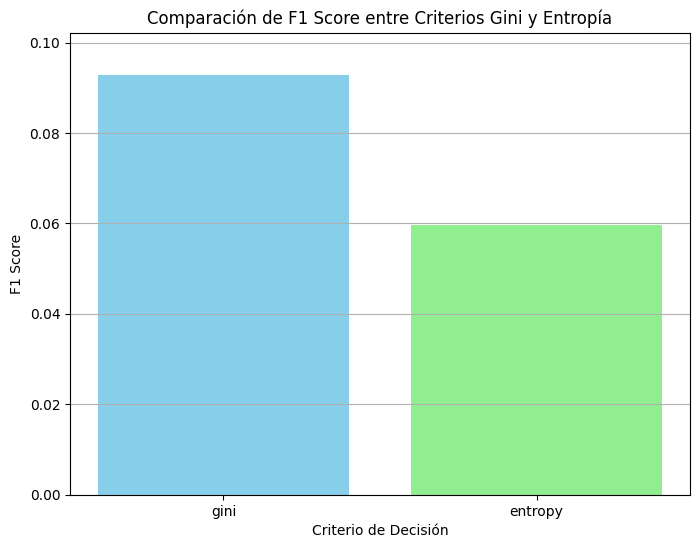

In [ ]:
# Creamos un ciclo que varía el criterio de decisión del árbol y grafica el F1 score en barras

criteria = ["gini", "entropy"]  # Criterios a comparar
f1_scores_criterion = {}

for crit in criteria:
    print(f"Entrenando Decision Tree con criterio: {crit}...")
    model = DecisionTreeClassifier(
        criterion=crit,
        max_depth=6,
        min_samples_leaf=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos el F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores_criterion[crit] = f1
    print(f"F1 Score para criterio={crit}: {f1:.4f}")

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(f1_scores_criterion.keys(), f1_scores_criterion.values(), color=['skyblue', 'lightgreen'])
plt.xlabel('Criterio de Decisión')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score entre Criterios Gini y Entropía')
plt.ylim(0, max(f1_scores_criterion.values()) * 1.1) # Ajusta el límite superior del eje y
plt.grid(axis='y')
plt.show()

Entrenando Decision Tree con max_depth: 1...
F1 Score para max_depth=1: 0.0000
Entrenando Decision Tree con max_depth: 2...
F1 Score para max_depth=2: 0.0000
Entrenando Decision Tree con max_depth: 3...
F1 Score para max_depth=3: 0.0000
Entrenando Decision Tree con max_depth: 4...
F1 Score para max_depth=4: 0.0000
Entrenando Decision Tree con max_depth: 5...
F1 Score para max_depth=5: 0.0598
Entrenando Decision Tree con max_depth: 6...
F1 Score para max_depth=6: 0.0929
Entrenando Decision Tree con max_depth: 7...
F1 Score para max_depth=7: 0.0891
Entrenando Decision Tree con max_depth: 8...
F1 Score para max_depth=8: 0.1312
Entrenando Decision Tree con max_depth: 9...
F1 Score para max_depth=9: 0.1297
Entrenando Decision Tree con max_depth: 10...
F1 Score para max_depth=10: 0.1670
Entrenando Decision Tree con max_depth: 11...
F1 Score para max_depth=11: 0.1660
Entrenando Decision Tree con max_depth: 12...
F1 Score para max_depth=12: 0.1547
Entrenando Decision Tree con max_depth: 13...


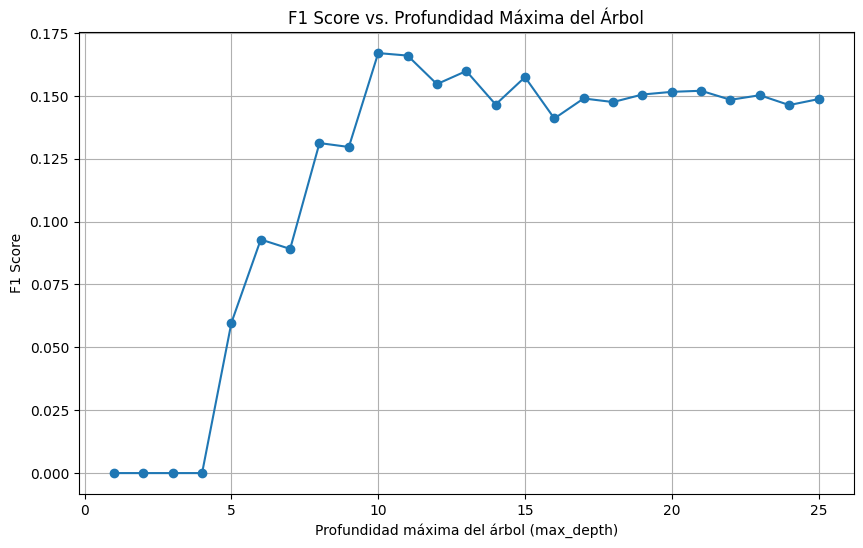

In [ ]:
# Creamos un ciclo que varía la profundidad del árbol y grafica el F1 score

depths = range(1, 26)  # Variamos la profundidad de 1 a 25
f1_scores_depth = {}

for depth in depths:
    print(f"Entrenando Decision Tree con max_depth: {depth}...")
    model = DecisionTreeClassifier(
        criterion='gini',
        max_depth=depth,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos el F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores_depth[depth] = f1
    print(f"F1 Score para max_depth={depth}: {f1:.4f}")

# Creamos el gráfico de puntos
plt.figure(figsize=(10, 6))
plt.plot(f1_scores_depth.keys(), f1_scores_depth.values(), marker='o', linestyle='-')
plt.xlabel('Profundidad máxima del árbol (max_depth)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Profundidad Máxima del Árbol')
plt.grid(True)
plt.show()

Entrenando Decision Tree con min_samples_split: 2...
F1 Score para min_samples_split=2: 0.1670
Entrenando Decision Tree con min_samples_split: 7...
F1 Score para min_samples_split=7: 0.1670
Entrenando Decision Tree con min_samples_split: 12...
F1 Score para min_samples_split=12: 0.1670
Entrenando Decision Tree con min_samples_split: 17...
F1 Score para min_samples_split=17: 0.1670
Entrenando Decision Tree con min_samples_split: 22...
F1 Score para min_samples_split=22: 0.1684
Entrenando Decision Tree con min_samples_split: 27...
F1 Score para min_samples_split=27: 0.1712
Entrenando Decision Tree con min_samples_split: 32...
F1 Score para min_samples_split=32: 0.1483
Entrenando Decision Tree con min_samples_split: 37...
F1 Score para min_samples_split=37: 0.1459
Entrenando Decision Tree con min_samples_split: 42...
F1 Score para min_samples_split=42: 0.1708
Entrenando Decision Tree con min_samples_split: 47...
F1 Score para min_samples_split=47: 0.1730
Entrenando Decision Tree con min_s

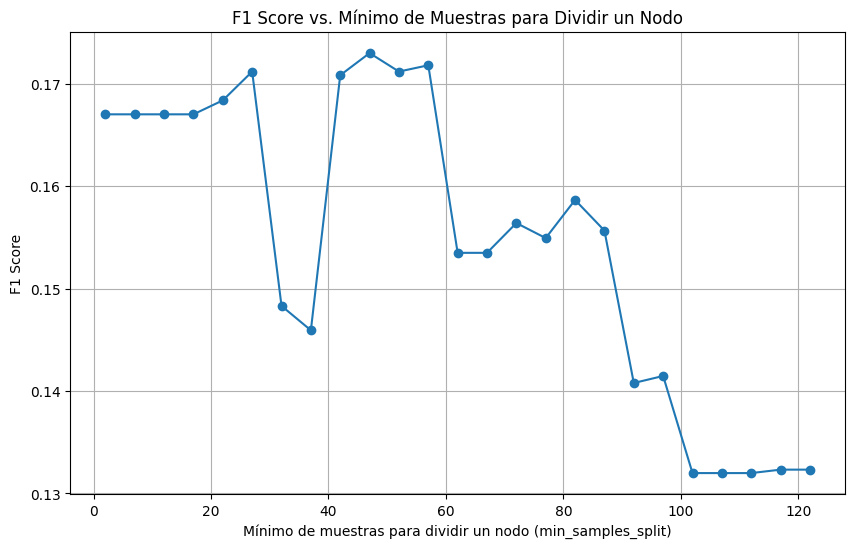

In [ ]:
# Creamos un ciclo que varía la cantidad mínima de muestras para dividir un nodo
# y grafica el F1 score

min_splits = range(2, 123, 5)  # Variamos min_samples_split de 2 a 100 en pasos de 10
f1_scores_split = {}

for split in min_splits:
    print(f"Entrenando Decision Tree con min_samples_split: {split}...")
    model = DecisionTreeClassifier(
        criterion='gini', # Usamos el óptimo encontrado
        max_depth=10, # Usamos el óptimo encontrado
        min_samples_split=split,
        min_samples_leaf=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos el F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores_split[split] = f1
    print(f"F1 Score para min_samples_split={split}: {f1:.4f}")

# Creamos el gráfico de puntos
plt.figure(figsize=(10, 6))
plt.plot(f1_scores_split.keys(), f1_scores_split.values(), marker='o', linestyle='-')
plt.xlabel('Mínimo de muestras para dividir un nodo (min_samples_split)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Mínimo de Muestras para Dividir un Nodo')
plt.grid(True)
plt.show()

Entrenando Decision Tree con min_samples_leaf: 1...
F1 Score para min_samples_leaf=1: 0.1807
Entrenando Decision Tree con min_samples_leaf: 6...
F1 Score para min_samples_leaf=6: 0.1807
Entrenando Decision Tree con min_samples_leaf: 11...
F1 Score para min_samples_leaf=11: 0.1725
Entrenando Decision Tree con min_samples_leaf: 16...
F1 Score para min_samples_leaf=16: 0.1708
Entrenando Decision Tree con min_samples_leaf: 21...
F1 Score para min_samples_leaf=21: 0.1261
Entrenando Decision Tree con min_samples_leaf: 26...
F1 Score para min_samples_leaf=26: 0.1591
Entrenando Decision Tree con min_samples_leaf: 31...
F1 Score para min_samples_leaf=31: 0.1504
Entrenando Decision Tree con min_samples_leaf: 36...
F1 Score para min_samples_leaf=36: 0.1618
Entrenando Decision Tree con min_samples_leaf: 41...
F1 Score para min_samples_leaf=41: 0.1759
Entrenando Decision Tree con min_samples_leaf: 46...
F1 Score para min_samples_leaf=46: 0.1239
Entrenando Decision Tree con min_samples_leaf: 51...
F

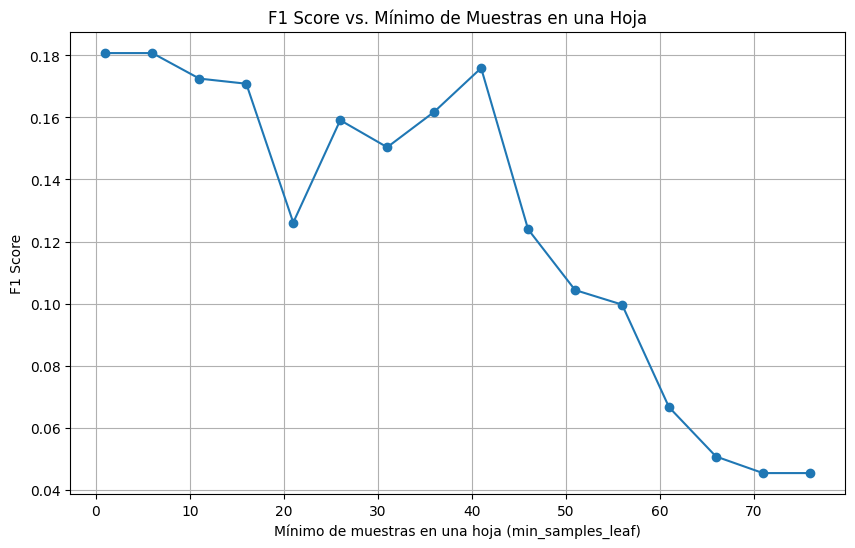

In [ ]:
# Creamos un ciclo que varía la cantidad mínima de muestras en una hoja
# y grafica el F1 score

min_leaf_samples = range(1, 81, 5)  # Variamos min_samples_leaf de 1 a 50 en pasos de 5
f1_scores_leaf = {}

for leaf in min_leaf_samples:
    print(f"Entrenando Decision Tree con min_samples_leaf: {leaf}...")
    model = DecisionTreeClassifier(
        criterion='gini',  # Usamos el criterio con mayor F1 score encontrado previamente
        max_depth=10,      # Usamos una profundidad óptima encontrada previamente
        min_samples_split=50, # Usamos el valor óptimo encontrado previamente
        min_samples_leaf=leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos el F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores_leaf[leaf] = f1
    print(f"F1 Score para min_samples_leaf={leaf}: {f1:.4f}")

# Creamos el gráfico de puntos
plt.figure(figsize=(10, 6))
plt.plot(f1_scores_leaf.keys(), f1_scores_leaf.values(), marker='o', linestyle='-')
plt.xlabel('Mínimo de muestras en una hoja (min_samples_leaf)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Mínimo de Muestras en una Hoja')
plt.grid(True)
plt.show()

## Métricas de evaluación

Matriz de confusión

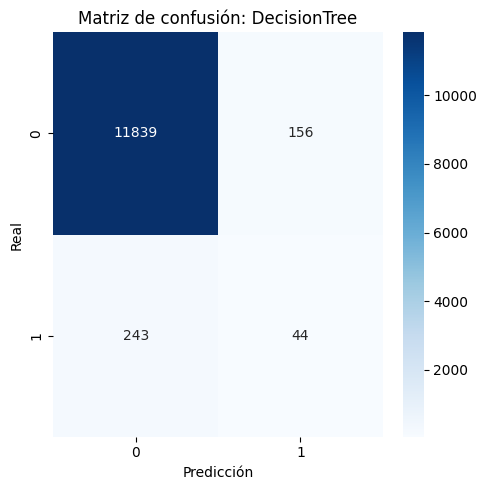

In [ ]:
def plot_confusion_matrices(y_true, predictions_dict):
    n_models = len(predictions_dict)

    # Calculamos filas y columnas necesarias dinámicamente
    n_cols = min(4, n_models)  # máximo 4 columnas
    n_rows = (n_models + n_cols - 1) // n_cols  # redondeo hacia arriba

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = np.array(axes).ravel()  # aplanar por si hay varias filas

    for idx, (name, y_pred) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'Matriz de confusión: {name}')
        axes[idx].set_xlabel('Predicción')
        axes[idx].set_ylabel('Real')

    # Ocultar subplots vacíos si hay menos modelos
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test, predictions)



Curva de ROC

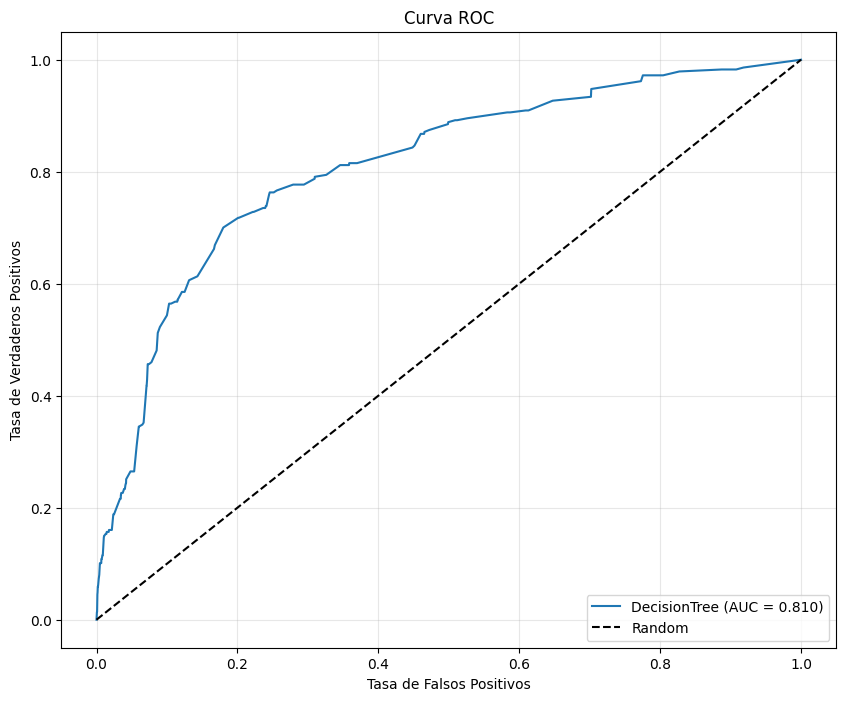

In [ ]:
def plot_roc_curves(y_true, probabilities_dict):
    plt.figure(figsize=(10, 8))

    best_auc = 0
    best_model = None

    for name, probs in probabilities_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)

        if auc > best_auc:
            best_auc = auc
            best_model = name

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(y_test, probabilities)

Tabla comparativa de métricas

In [ ]:
print("\n Métricas de evaluación del modelo")
print("=" * 85)
print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10}")
print("-" * 85)

best_model = None
best_auc = 0

for name in predictions.keys():
    # Reporte de métricas
    report = classification_report(y_test, predictions[name], output_dict=True, zero_division=0)
    auc = roc_auc_score(y_test, probabilities[name])

    print(f"{name:<15} "
          f"{report['accuracy']:<10.3f} "
          f"{report['1']['precision']:<10.3f} "
          f"{report['1']['recall']:<10.3f} "
          f"{report['1']['f1-score']:<10.3f} "
          f"{auc:<10.3f}")

    if auc > best_auc:
        best_auc = auc
        best_model = name


 Métricas de evaluación del modelo
Modelo          Accuracy   Precision  Recall     F1-Score   AUC-ROC   
-------------------------------------------------------------------------------------
DecisionTree    0.968      0.220      0.153      0.181      0.810     


Validación Cruzada

Validación cruzada K-Fold (normal) para DecisionTree...
  F1 por fold: [0.07263923 0.08181027 0.06343284 0.09174312 0.07951599]
  Promedio: 0.078 | Desviación: 0.009

Validación cruzada StratifiedKFold para DecisionTree...
  F1 por fold: [0.12006861 0.12651646 0.11159547 0.09115282 0.1043771 ]
  Promedio: 0.111 | Desviación: 0.012



/tmp/ipython-input-1810687078.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_cv, labels=models.keys())
/tmp/ipython-input-1810687078.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_cv_strat, labels=models.keys())


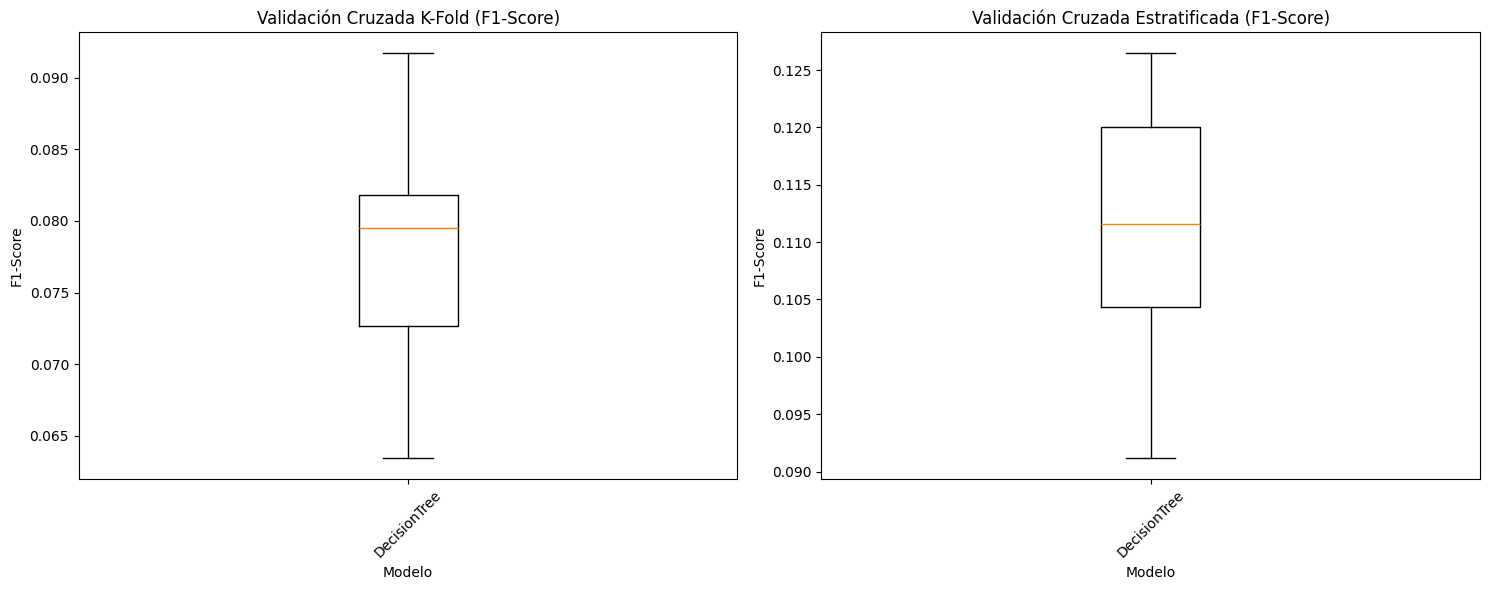


 Resultados de Validación Cruzada (F1-Score):
----------------------------------------------------------------------
Modelo          CV Normal (media±std)     CV Estratificado (media±std)
----------------------------------------------------------------------
DecisionTree    0.078±0.009          0.111±0.012


In [ ]:

cv_scores = {}
cv_scores_stratified = {}

kfold = 5

for name, model in models.items():
    print(f"Validación cruzada K-Fold (normal) para {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    cv_scores[name] = scores
    print(f"  F1 por fold: {scores}")
    print(f"  Promedio: {scores.mean():.3f} | Desviación: {scores.std():.3f}\n")

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"Validación cruzada StratifiedKFold para {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=skfold, scoring='f1')
    cv_scores_stratified[name] = scores
    print(f"  F1 por fold: {scores}")
    print(f"  Promedio: {scores.mean():.3f} | Desviación: {scores.std():.3f}\n")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

data_cv = [cv_scores[name] for name in models.keys()]
ax1.boxplot(data_cv, labels=models.keys())
ax1.set_title('Validación Cruzada K-Fold (F1-Score)')
ax1.set_xlabel('Modelo')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)

data_cv_strat = [cv_scores_stratified[name] for name in models.keys()]
ax2.boxplot(data_cv_strat, labels=models.keys())
ax2.set_title('Validación Cruzada Estratificada (F1-Score)')
ax2.set_xlabel('Modelo')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


print("\n Resultados de Validación Cruzada (F1-Score):")
print("-" * 70)
print(f"{'Modelo':<15} {'CV Normal (media±std)':<25} {'CV Estratificado (media±std)':<25}")
print("-" * 70)

for name in models.keys():
    mean_cv = np.mean(cv_scores[name])
    std_cv = np.std(cv_scores[name])
    mean_cv_strat = np.mean(cv_scores_stratified[name])
    std_cv_strat = np.std(cv_scores_stratified[name])

    print(f"{name:<15} "
          f"{mean_cv:.3f}±{std_cv:.3f}{'':>10}"
          f"{mean_cv_strat:.3f}±{std_cv_strat:.3f}")